In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import random 
from scipy import interpolate

In [3]:
K = 600 # number of OFDM subcarriers 
CP = K // 4 # lenth of the cyclic prefix : 25 % of the block

In [4]:
P = 100 # number of pilot carriers per OFDM block 
pilotvalue = 3 + 3j # The known value each pilot transmits 

In [5]:
allCarriers = np.arange(K)
pilotCarriers = allCarriers[::K//100]
pilotCarriers = np.hstack([pilotCarriers, np.array([allCarriers[-1]])])
pilotCarriers

array([  0,   6,  12,  18,  24,  30,  36,  42,  48,  54,  60,  66,  72,
        78,  84,  90,  96, 102, 108, 114, 120, 126, 132, 138, 144, 150,
       156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228,
       234, 240, 246, 252, 258, 264, 270, 276, 282, 288, 294, 300, 306,
       312, 318, 324, 330, 336, 342, 348, 354, 360, 366, 372, 378, 384,
       390, 396, 402, 408, 414, 420, 426, 432, 438, 444, 450, 456, 462,
       468, 474, 480, 486, 492, 498, 504, 510, 516, 522, 528, 534, 540,
       546, 552, 558, 564, 570, 576, 582, 588, 594, 599])

In [6]:
dataCarriers = np.delete(allCarriers, pilotCarriers)

pilotCarriers:  [  0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 102
 108 114 120 126 132 138 144 150 156 162 168 174 180 186 192 198 204 210
 216 222 228 234 240 246 252 258 264 270 276 282 288 294 300 306 312 318
 324 330 336 342 348 354 360 366 372 378 384 390 396 402 408 414 420 426
 432 438 444 450 456 462 468 474 480 486 492 498 504 510 516 522 528 534
 540 546 552 558 564 570 576 582 588 594 599]
dataCarriers:  [  1   2   3   4   5   7   8   9  10  11  13  14  15  16  17  19  20  21
  22  23  25  26  27  28  29  31  32  33  34  35  37  38  39  40  41  43
  44  45  46  47  49  50  51  52  53  55  56  57  58  59  61  62  63  64
  65  67  68  69  70  71  73  74  75  76  77  79  80  81  82  83  85  86
  87  88  89  91  92  93  94  95  97  98  99 100 101 103 104 105 106 107
 109 110 111 112 113 115 116 117 118 119 121 122 123 124 125 127 128 129
 130 131 133 134 135 136 137 139 140 141 142 143 145 146 147 148 149 151
 152 153 154 155 157 158 159 160 161 163 164 16

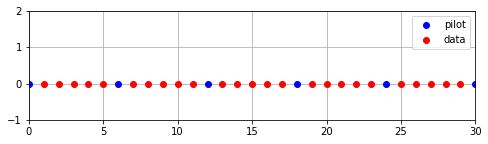

In [7]:
allCarriers = np.arange(K) # indices of all subcarriers

pilotCarriers = allCarriers[::K//P]

# For convenience of channel estimation, let's make the last carriers also be a pilot 
pilotCarriers = np.hstack([pilotCarriers, np.array([allCarriers[-1]])])
P += 1 

# Data Carriers are all remaining carriers 
dataCarriers = np.delete(allCarriers, pilotCarriers)

# print("allCarriers: ", allCarriers)
print("pilotCarriers: ", pilotCarriers)
print("dataCarriers: ", dataCarriers)
plt.figure(figsize=(8, 2))
plt.plot(pilotCarriers, np.zeros_like(pilotCarriers), 'bo', label='pilot')
plt.plot(dataCarriers, np.zeros_like(dataCarriers), 'ro', label='data')
plt.xlim([0, 30]); plt.ylim([-1, 2])
plt.grid()
plt.legend() 
plt.show()

In [8]:
mu = 4
len(dataCarriers) * mu

1996

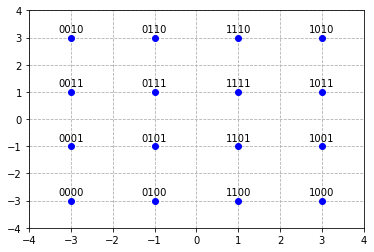

In [9]:
mu = 4 # bits per symbol (i.e., 16QAM)
payloadBits_per_OFDM = len(dataCarriers) * mu # number of payload bits per OFDM symbol

mapping_table = {
    (0, 0, 0, 0) : -3-3j,
    (0, 0, 0, 1) : -3-1j,
    (0, 0, 1, 0) : -3+3j,
    (0, 0, 1, 1) : -3+1j,
    (0, 1, 0, 0) : -1-3j,
    (0, 1, 0, 1) : -1-1j,
    (0, 1, 1, 0) : -1+3j,
    (0, 1, 1, 1) : -1+1j,
    (1, 0, 0, 0) :  3-3j,
    (1, 0, 0, 1) :  3-1j,
    (1, 0, 1, 0) :  3+3j,
    (1, 0, 1, 1) :  3+1j,
    (1, 1, 0, 0) :  1-3j,
    (1, 1, 0, 1) :  1-1j,
    (1, 1, 1, 0) :  1+3j,
    (1, 1, 1, 1) :  1+1j,
}
demapping_table = {v : k for k, v in mapping_table.items()}

plt.figure()
for b3 in [0, 1]:
    for b2 in [0, 1]:
        for b1 in [0, 1]:
            for b0 in [0, 1]:
                B = (b3, b2, b1, b0) 
                Q = mapping_table[B]
                plt.plot(Q.real, Q.imag, 'bo')
                plt.text(Q.real, Q.imag+0.2, "".join(str(x) for x in B), ha='center')
plt.axis([-4, 4, -4, 4])
plt.grid(True, linestyle="--")
plt.show()

In [13]:
type(mapping_table[(0, 0, 0, 0)])

complex

In [36]:
np.arange(0, 35, 5)

array([ 0,  5, 10, 15, 20, 25, 30])

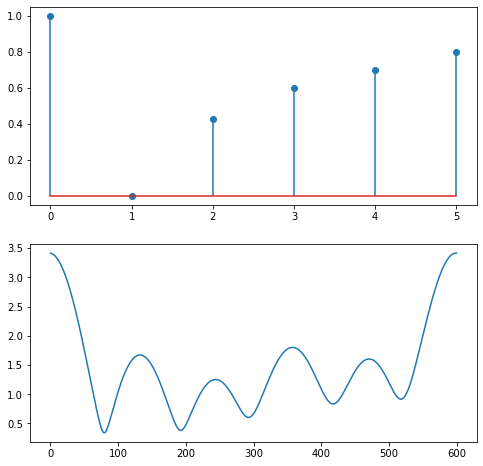

In [9]:
channelResponse = np.array([1, 0, 0.3+0.3j, 0.6, 0.7, 0.8])
H_exact = np.fft.fft(channelResponse, K)
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.stem(np.abs(channelResponse))
plt.subplot(2, 1, 2)
plt.plot(allCarriers, abs(H_exact))
plt.show()

SNRdb = 5

In [10]:
bits = np.random.binomial(n=1, p=0.5, size=(10, ))
bits

array([1, 1, 0, 1, 1, 0, 1, 0, 1, 1])

In [11]:
bits = np.random.binomial(n=1, p=0.5, size=(payloadBits_per_OFDM, ))
print("Bits count: ", len(bits))
print("First 20bits: ", bits[:20])
print("Mean of bits (should be around 0.5) ", np.mean(bits))

Bits count:  1996
First 20bits:  [0 1 1 1 0 0 0 0 1 1 1 1 1 1 0 0 1 0 0 0]
Mean of bits (should be around 0.5)  0.48997995991983967


In [12]:
def SP(bits):
    return bits.reshape((len(dataCarriers), mu))

bits_SP = SP(bits)
print("FIRST 5 bit groups")
print(bits_SP[:5, :])

FIRST 5 bit groups
[[0 1 1 1]
 [0 0 0 0]
 [1 1 1 1]
 [1 1 0 0]
 [1 0 0 0]]


In [13]:
def mapping(bits):
    return np.array([mapping_table[tuple(b)] for b in bits])
QAM = mapping(bits_SP)
print("First 5QAM symbols and bits")
print(bits_SP[:5, :])
print(QAM[:5])

First 5QAM symbols and bits
[[0 1 1 1]
 [0 0 0 0]
 [1 1 1 1]
 [1 1 0 0]
 [1 0 0 0]]
[-1.+1.j -3.-3.j  1.+1.j  1.-3.j  3.-3.j]


In [14]:
def OFDM_symbol(QAM_payload):
    symbol = np.zeros(K, dtype=complex) # the overall K subcarriers
    symbol[pilotCarriers] = pilotvalue
    symbol[dataCarriers] = QAM_payload
    return symbol

OFDM_data = OFDM_symbol(QAM)
print("Number of OFDM carriers in frequency domain: ", len(OFDM_data))
print(OFDM_data[:5])

Number of OFDM carriers in frequency domain:  600
[ 3.+3.j -1.+1.j -3.-3.j  1.+1.j  1.-3.j]


In [15]:
def IDFT(OFDM_data):
    return np.fft.ifft(OFDM_data)

OFDM_time = IDFT(OFDM_data)
print("number of OFDM sample in time-domain before CP: ", len(OFDM_time))
print(OFDM_time[:5])

number of OFDM sample in time-domain before CP:  600
[ 0.55666667+0.37666667j  0.10946407-0.08716976j  0.02170393+0.14099178j
  0.03267172-0.02569474j -0.14889042-0.00618367j]


In [16]:
def addCP(OFDM_time):
    cp = OFDM_time[-CP:]
    return np.hstack([cp, OFDM_time])

OFDM_withCP = addCP(OFDM_time)
print("number of OFDM samples in time domain with CP: ", len(OFDM_withCP))

number of OFDM samples in time domain with CP:  750


RX signal power : 0.0488. Noise power: 0.0154


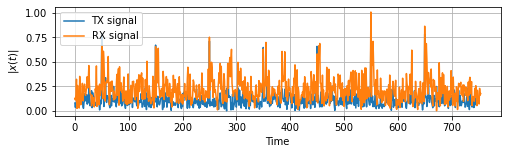

In [17]:
def channel(signal):
    convolved = np.convolve(signal, channelResponse)
    signal_power = np.mean(abs(convolved**2))
    sigma2 = signal_power * 10**(-SNRdb/10)

    print(f"RX signal power : {signal_power:.4f}. Noise power: {sigma2:.4f}")

    noise = np.sqrt(sigma2/2) * (np.random.randn(*convolved.shape)+1j*np.random.randn(*convolved.shape))
    return convolved + noise 

OFDM_TX = OFDM_withCP
OFDM_RX = channel(OFDM_TX)
plt.figure(figsize=(8, 2))
plt.plot(abs(OFDM_TX), label='TX signal')
plt.plot(abs(OFDM_RX), label='RX signal') 
plt.legend() 
plt.xlabel("Time"); plt.ylabel("$|x(t)|$")
plt.grid()
plt.show()

In [18]:
def removeCP(signal):
    return signal[CP:(CP+K)]
OFDM_RX_noCP = removeCP(OFDM_RX) 

In [19]:
def DFT(OFDM_RX):
    return np.fft.fft(OFDM_RX)

OFDM_demod = DFT(OFDM_RX_noCP)


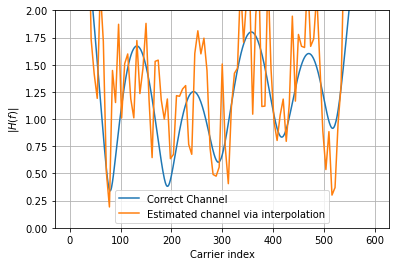

In [20]:
def channelEstimate(OFDM_demod):
    pilots = OFDM_demod[pilotCarriers]
    Hest_at_pilots = pilots / pilotvalue

    Hest_abs = interpolate.interp1d(pilotCarriers, abs(Hest_at_pilots), kind='linear')(allCarriers)
    Hest_phase = interpolate.interp1d(pilotCarriers, np.angle(Hest_at_pilots), kind='linear')(allCarriers)
    Hest = Hest_abs * np.exp(1j * Hest_phase)

    plt.plot(allCarriers, abs(H_exact), label="Correct Channel")
    # plt.stem(pilotCarriers, abs(Hest_at_pilots), label='Pilot estimates') 
    plt.plot(allCarriers, abs(Hest), label="Estimated channel via interpolation")
    plt.grid(True); plt.xlabel("Carrier index"); plt.ylabel("$|H(f)|$"); plt.legend(fontsize=10)
    plt.ylim(0, 2)

    return Hest
Hest = channelEstimate(OFDM_demod=OFDM_demod)

In [21]:
from scipy import interpolate

In [22]:
def equalize(OFDM_demod, Hest):
    return OFDM_demod / Hest 

equalized_Hest = equalize(OFDM_demod, Hest) 

499


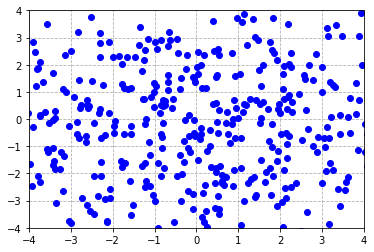

In [25]:
def get_payload(equalized):
    return equalized[dataCarriers]

QAM_est = get_payload(equalized_Hest)
print(QAM_est.size)
plt.figure()
plt.plot(QAM_est.real, QAM_est.imag, 'bo')
plt.grid(True, linestyle='--')
plt.axis([-4, 4, -4, 4])
plt.show()

In [34]:
x = QAM.reshape((-1, 1))


(499, 1)

(499,)
(16,)


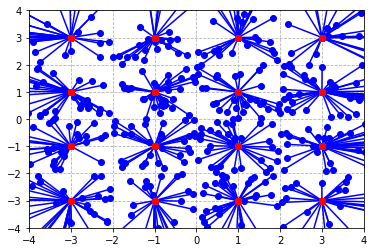

In [30]:
def Demapping(QAM):
    # array of possible constellation points 
    constellation = np.array([x for x in demapping_table.keys()])

    # calculate distance of each RX point to each possible point 
    dists = abs(QAM.reshape((-1, 1)) - constellation.reshape((1, -1)))
    print(QAM.shape)
    print(constellation.shape)
    # for each element in QAM, choose the index in constellation 
    # that belongs to the nearest constellation point 
    const_index = dists.argmin(axis = 1)

    # get back the real constellation point 
    hardDecision = constellation[const_index]

    # transform the constellation point into the bit groups
    return np.vstack([demapping_table[C] for C in hardDecision]), hardDecision

PS_est, hardDecision = Demapping(QAM_est)
plt.figure()
for qam, hard in zip(QAM_est, hardDecision):
    plt.plot([qam.real, hard.real], [qam.imag, hard.imag], 'b-o')
    plt.plot(hardDecision.real, hardDecision.imag, 'ro')
plt.grid(True, linestyle='--')
plt.axis([-4, 4, -4, 4])
plt.show()


In [80]:
def PS(bits):
    return bits.reshape((-1, ))

bits_est = PS(PS_est)


In [81]:
print("obtained Bit error rate: ", np.sum(abs(bits-bits_est)) / len(bits))

obtained Bit error rate:  0.26826722338204595


https://dspillustrations.com/pages/posts/misc/python-ofdm-example.html